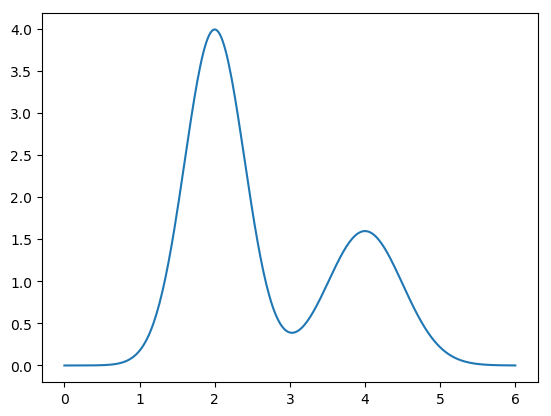

In [1]:
using PyCall
include("../src/gauss_error.jl")
include("../src/kernels.jl")

a = 0.
b = 6.

function phi(x::Float64)
    mu1 = 2.
    mu2 = 4.
    n1 = 4.
    n2 = 2.
    sig1 = 0.4
    sig2 = 0.5

    norm(n, mu, sig, x) = n / sqrt(2 * pi*sig^2) * exp(-(x - mu)^2 / (2 * sig^2))
    return norm(n1, mu1, sig1, x) + norm(n2, mu2, sig2, x)
end

# function phi(x::Float64)
#     return cos(x)
# end

x = collect(range(a, stop=b, length=300))

using PyPlot
myplot = plot(x, phi.(x))
savefig("function.png", dpi=1000)

In [2]:
function kernel(x::Float64, y::Float64)
    return getOpticsKernels("gaussian")(x, y)
end

kernel (generic function with 1 method)

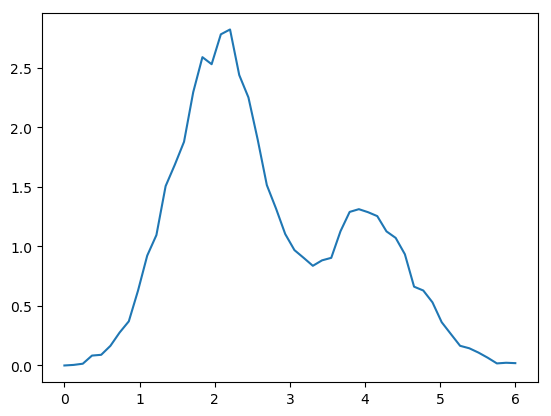

In [3]:
convolution = y -> quadgk(x -> kernel(x,y) * phi(x), a, b, maxevals=10^7)[1]
y = collect(range(a, stop = b, length=50))
ftrue = convolution.(y)
sig = 0.05*abs.(ftrue) +[0.01 for i = 1:Base.length(ftrue)]
using Compat, Random, Distributions
noise = []
for sigma in sig
    n = rand(Normal(0., sigma), 1)[1]
    push!(noise, n)
end
f = ftrue + noise
# f = [0.0250447, 0.0259323, 0.0300055, 0.0697762, 0.106568, 0.199481, 0.286887, 0.448353, 0.564742, 0.793431, 1.18831, 1.41718, 1.73265, 2.2737, 2.37566, 2.64492, 2.82908, 2.52841, 2.51898, 2.64624, 2.22185, 1.75508, 1.48881, 1.2669, 1.09605, 0.953436, 0.859025, 0.994736, 0.938362, 1.04007, 1.11036, 1.17168, 1.2502, 1.15296, 1.20842, 1.05919, 1.0105, 0.859411, 0.714523, 0.612392, 0.508907, 0.396421, 0.264456, 0.205983, 0.125906, 0.0530743, 0.0718868, 0.0308666, 0.0121104, 0.0207568]
plot(y, f)
savefig("integrated_function.png", dpi=1000)

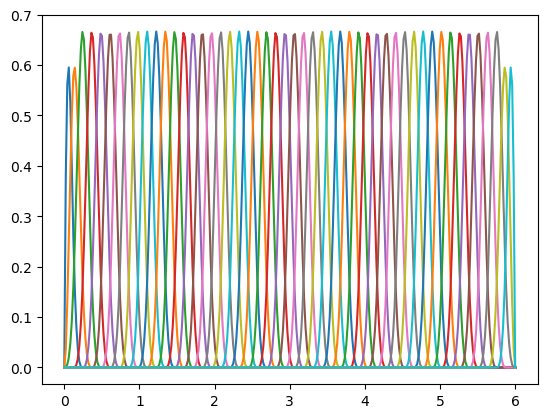

┌ Info: Cubic spline basis is created.
└ @ Main /Users/ta_nyan/Documents/diploma/StatReg.jl/src/basis.jl:234


In [4]:
basis = CubicSplineBasis(y, "dirichlet")
for basis_function in basis.basis_functions
    plot(x, basis_function.f.(x))
end
savefig("basis.png", dpi=1000)

In [5]:
# @time discretize_kernel(basis, kernel, y)

Kmn = discretize_kernel(basis, kernel, y)

┌ Info: Starting discretize kernel...
└ @ Main /Users/ta_nyan/Documents/diploma/StatReg.jl/src/basis.jl:48
┌ Info: Kernel was discretized successfully.
└ @ Main /Users/ta_nyan/Documents/diploma/StatReg.jl/src/basis.jl:59


50×50 Array{Float64,2}:
 0.0564223    0.0806035    0.0965189    …  2.92235e-42  8.08106e-44
 0.0568853    0.0853341    0.108971        1.38854e-40  4.15223e-42
 0.0528153    0.0832629    0.113468        6.07839e-39  1.96507e-40
 0.0451581    0.0748768    0.108971        2.45149e-37  8.56574e-39
 0.0355576    0.0620605    0.0965189       9.10946e-36  3.43908e-37
 0.0257843    0.0474092    0.0788467    …  3.11879e-34  1.27179e-35
 0.017219     0.0333805    0.0594047       9.83828e-33  4.33195e-34
 0.0105901    0.0216627    0.0412783       2.85958e-31  1.3591e-32 
 0.0059983    0.0129576    0.0264535       7.65849e-30  3.92757e-31
 0.00312899   0.00714389   0.0156352       1.88996e-28  1.04544e-29
 0.00150324   0.00363032   0.0085227    …  4.29773e-27  2.5632e-28 
 0.000665135  0.00170043   0.0042845       9.00557e-26  5.78859e-27
 0.00027105   0.000734141  0.0019864       1.73891e-24  1.20413e-25
 ⋮                                      ⋱                          
 5.78859e-27  9.00557e-2

In [13]:
model = GaussErrorMatrixUnfolder([omega(basis, 2)])

┌ Info: GaussErrorMatrixUnfolder is created
└ @ Main /Users/ta_nyan/Documents/diploma/StatReg.jl/src/gauss_error.jl:86


GaussErrorMatrixUnfolder(Array{Float64,2}[[13072.1 -3676.53 … 0.0 0.0; -3676.53 2451.02 … 0.0 0.0; … ; 0.0 0.0 … 2451.02 -3676.53; 0.0 0.0 … -3676.53 13072.1]], 50, "EmpiricalBayes", nothing)

In [14]:
# @time solve(model, Kmn, f, sig)

result = solve(model, Kmn, f, sig)

┌ Info: Starting solve...
└ @ Main /Users/ta_nyan/Documents/diploma/StatReg.jl/src/gauss_error.jl:117
┌ Info: Ending solve...
└ @ Main /Users/ta_nyan/Documents/diploma/StatReg.jl/src/gauss_error.jl:145
┌ Info: Starting solve_correct...
└ @ Main /Users/ta_nyan/Documents/diploma/StatReg.jl/src/gauss_error.jl:156
┌ Info: Starting find_optimal_alpha...
└ @ Main /Users/ta_nyan/Documents/diploma/StatReg.jl/src/gauss_error.jl:164
┌ Info: Starting optimization...
└ @ Main /Users/ta_nyan/Documents/diploma/StatReg.jl/src/gauss_error.jl:186


Iter     Function value   Gradient norm 
     0    -7.665546e+02     2.514780e+01
     1    -7.899166e+02     8.638871e+00
     2    -8.031778e+02     9.229036e-01
     3    -8.032547e+02     2.056874e-02
     4    -8.032548e+02     4.388917e-07
     5    -8.032548e+02     2.825741e-07
     6    -8.032548e+02     3.877879e-07
     7    -8.032548e+02     1.563176e-07
     8    -8.032548e+02     3.306718e-08


┌ Info: Optimized successfully.
└ @ Main /Users/ta_nyan/Documents/diploma/StatReg.jl/src/gauss_error.jl:202
┌ Info: Ending solve_correct...
└ @ Main /Users/ta_nyan/Documents/diploma/StatReg.jl/src/gauss_error.jl:217


Dict{String,Array{Float64,N} where N} with 3 entries:
  "errors" => [0.00435132 0.00847074 … -1.67312e-6 -5.48824e-7; 0.00847074 0.02…
  "alphas" => [0.0440385]
  "coeff"  => [-0.000284959, -0.00121488, -0.0166239, -0.0458321, -0.0765536, -…

In [15]:
phivec = PhiVec(result, basis)

┌ Info: PhiVec is created.
└ @ Main /Users/ta_nyan/Documents/diploma/StatReg.jl/src/vector.jl:69


PhiVec([-0.000284959, -0.00121488, -0.0166239, -0.0458321, -0.0765536, -0.0874746, -0.052875, 0.0518835, 0.244986, 0.533836  …  0.320057, 0.168081, 0.0708047, 0.0211059, 0.00592069, 0.00984818, 0.0186363, 0.0219654, 0.0151993, 0.00511869], CubicSplineBasis(0.0, 6.0, [0.0, 0.0, 0.0, 0.0, 0.122449, 0.244898, 0.367347, 0.489796, 0.612245, 0.734694  …  5.26531, 5.38776, 5.5102, 5.63265, 5.7551, 5.87755, 6.0, 6.0, 6.0, 6.0], BaseFunction[BaseFunction(BSpline(1, 3, [0.0, 0.0, 0.0, 0.0, 0.122449, 0.244898, 0.367347, 0.489796, 0.612245, 0.734694  …  5.26531, 5.38776, 5.5102, 5.63265, 5.7551, 5.87755, 6.0, 6.0, 6.0, 6.0], ##39#41{Int64,Int64,Array{Float64,1}}(1, 3, [0.0, 0.0, 0.0, 0.0, 0.122449, 0.244898, 0.367347, 0.489796, 0.612245, 0.734694  …  5.26531, 5.38776, 5.5102, 5.63265, 5.7551, 5.87755, 6.0, 6.0, 6.0, 6.0], Box(#b_spline_function#40(Box(#= circular reference @-2 =#))))), (0.0, 6.0)), BaseFunction(BSpline(2, 3, [0.0, 0.0, 0.0, 0.0, 0.122449, 0.244898, 0.367347, 0.489796, 0.612245, 0.

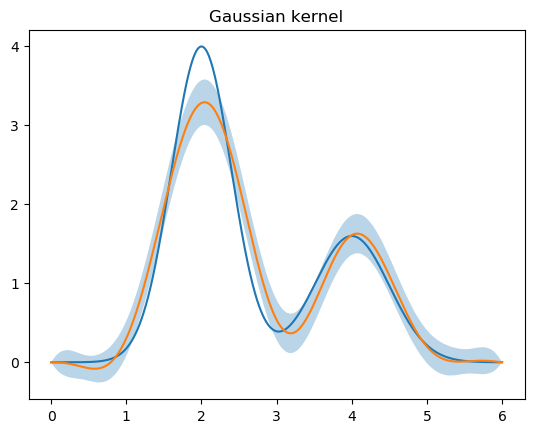

PyObject Text(0.5, 1.0, 'Gaussian kernel')

In [20]:
x = collect(range(a, stop=b, length=5000))
plot(x, phi.(x))

phi_reconstructed = phivec.phi_function.(x)
phi_reconstructed_errors = phivec.error_function.(x)

plot(x, phi_reconstructed)
fill_between(x, phi_reconstructed - phi_reconstructed_errors, phi_reconstructed + phi_reconstructed_errors, alpha=0.3)
title("Gaussian kernel")
# savefig("result.png", dpi=1000)

In [21]:
print(f)

[-0.000287895, 0.00446601, 0.0145426, 0.0828676, 0.0893164, 0.164438, 0.276171, 0.370378, 0.627746, 0.921876, 1.0945, 1.50522, 1.68499, 1.87735, 2.2941, 2.58794, 2.52883, 2.77961, 2.82034, 2.43787, 2.24968, 1.8981, 1.5138, 1.31654, 1.10272, 0.968129, 0.903313, 0.836484, 0.882308, 0.903313, 1.12595, 1.28886, 1.3118, 1.28641, 1.25354, 1.12544, 1.0707, 0.933528, 0.661206, 0.629071, 0.529599, 0.363076, 0.263525, 0.164843, 0.144158, 0.107789, 0.0648774, 0.017028, 0.0224722, 0.0193508]

In [22]:
print(result["errors"])

[0.00435132 0.00847074 0.00720664 0.00303299 -0.00118217 -0.00398016 -0.00496024 -0.00439546 -0.00287991 -0.00105433 0.000568485 0.00168134 0.00218451 0.0021402 0.00170734 0.00107804 0.000428132 -0.000112812 -0.000473082 -0.00063575 -0.000626236 -0.000495618 -0.000303891 -0.000106161 5.65498e-5 0.000161427 0.000203434 0.00019155 0.000143225 7.85881e-5 1.56204e-5 -3.29645e-5 -6.09404e-5 -6.81257e-5 -5.88029e-5 -3.96223e-5 -1.75551e-5 1.69458e-6 1.46051e-5 2.00539e-5 1.89551e-5 1.35261e-5 6.4271e-6 -8.55244e-9 -4.28967e-6 -5.95319e-6 -5.43002e-6 -3.67336e-6 -1.67312e-6 -5.48824e-7; 0.00847074 0.0277081 0.0212844 0.00952009 -0.00335643 -0.0117737 -0.0148184 -0.0132022 -0.00871472 -0.0032659 0.00160217 0.00496101 0.00650167 0.0064016 0.00513071 0.0032613 0.00131992 -0.000303517 -0.00139126 -0.00188944 -0.00187147 -0.00148845 -0.000919152 -0.000328592 0.000159762 0.000476611 0.00060583 0.000573426 0.000431065 0.000238762 5.04041e-5 -9.56904e-5 -0.000180527 -0.000203211 -0.000176288 -0.00011

0119138 0.000756017 0.000252612; 5.65498e-5 0.000159762 -7.12648e-5 -0.000706746 -0.00149303 -0.00201964 -0.00186863 -0.000770488 0.00126704 0.00389017 0.00641421 0.00793198 0.00750717 0.00442626 -0.00153288 -0.00987018 -0.0192313 -0.0274386 -0.0317356 -0.0293004 -0.0179806 0.00257778 0.0302446 0.0574584 0.0767428 0.055407 0.0267629 -0.00127751 -0.0210277 -0.030568 -0.0307214 -0.0242197 -0.0144063 -0.0043658 0.00365482 0.00847822 0.00994932 0.00869198 0.00576948 0.00233951 -0.000626212 -0.00251651 -0.00313744 -0.00266479 -0.00152361 -0.000234409 0.000736382 0.00109316 0.000780209 0.000262039; 0.000161427 0.000476611 0.000530385 5.05034e-5 -0.000817618 -0.00173356 -0.00226575 -0.00202081 -0.000775648 0.00141598 0.00416963 0.0067902 0.00837544 0.00799787 0.00494443 -0.00102255 -0.00943348 -0.0189693 -0.0274757 -0.032192 -0.0302539 -0.0194321 0.000723125 0.0281711 0.055407 0.0749605 0.0540928 0.0260268 -0.00143155 -0.0206925 -0.0299034 -0.029915 -0.02345 -0.0138156 -0.00404505 0.00367074 

 -0.00251955; 6.4271e-6 1.9597e-5 4.32878e-5 6.4488e-5 7.15031e-5 5.27766e-5 2.499e-6 -7.50046e-5 -0.000163428 -0.000236043 -0.000260815 -0.000208382 -6.14844e-5 0.000176154 0.000473729 0.000772241 0.000990122 0.0010365 0.000831639 0.000332207 -0.000443118 -0.00139438 -0.00233536 -0.00301035 -0.00313744 -0.00247696 -0.000915957 0.00144922 0.00425717 0.00687947 0.00849493 0.0082496 0.00549229 4.98064e-5 -0.00751926 -0.015776 -0.0224476 -0.0247688 -0.0201228 -0.00718781 0.0132332 0.0350124 0.0519009 0.0319338 0.00844533 -0.0113745 -0.0211669 -0.0206585 -0.0122758 -0.00408503; -8.55244e-9 2.95572e-7 1.14225e-5 3.22639e-5 5.37811e-5 6.29873e-5 4.79869e-5 2.91095e-6 -6.84079e-5 -0.000151046 -0.000220531 -0.000247391 -0.000204183 -7.38462e-5 0.000142222 0.000418287 0.000702591 0.000921627 0.000991428 0.000835795 0.00040956 -0.000277151 -0.00113982 -0.00201316 -0.00266479 -0.00283351 -0.00229149 -0.000922187 0.00120228 0.00376693 0.00620804 0.00777663 0.00768171 0.0053053 0.000458154 -0.00637

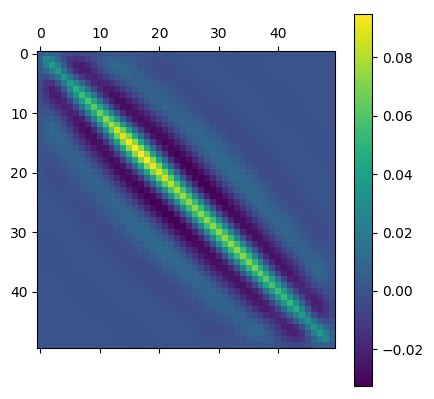

PyObject <matplotlib.colorbar.Colorbar object at 0x18b340ac8>

In [23]:
matshow(result["errors"])
colorbar()